# Mask R-CNN Training and Inference
In this notebook we use Matterport's implementation of Mask R-CNN to train on our synthetic dataset, then use the trained weights to run inference on new images.

If you've never trained a neural network before, I wouldn't recommend starting here. Find a beginner deep learning tutorial/course and start there. I'd suggest the free course at https://course.fast.ai/. There are also lots of great free tutorials on YouTube, as well as paid courses on Udemy, Udacity, Coursera, etc.

## TensorFlow GPU
You definitely want TensorFlow GPU installed to run this notebook. Installation instructions are here:
https://www.tensorflow.org/install/gpu

This includes installing CUDA, which is no small task. If you want to do serious image recognition, you just have to push through the pain.

When I created this notebook, I updated my graphics driver to the latest, then installed the CUDA Toolkit and CUDNN. Tensorflow tends to not work if you have the wrong combo of CUDA/CUDNN, so I recommend checking out the [tested build configurations](https://www.tensorflow.org/install/source#tested_build_configurations). It took me a few frustrating hours of searching and trial and error to get a combination that worked.

My combo that worked:
- **Python 3.6** (conda create -n tf-gpu python=3.6)
- **CUDA Toolkit 10.0** [https://developer.nvidia.com/cuda-zone](https://developer.nvidia.com/cuda-zone)
- **CUDNN 7.4.1** [https://developer.nvidia.com/cudnn](https://developer.nvidia.com/cudnn)
- **tensorflow-gpu 1.13.1** (pip install tensorflow-gpu==1.13.1)

In [25]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import os
import sys
import json
import numpy as np
import time
import imgaug
from PIL import Image, ImageDraw
from pathlib import Path

# Import Matterport's "mrcnn" libraries
I'm using Matterport's Mask_RCNN git repo: https://github.com/matterport/Mask_RCNN

- Clone the Mask_RCNN repo to your computer.
- Update the code cell below to point to the root directory of the repo.
- Use pip to install everything from the requirements.txt file in that repo.

Read through their documentation and issues if you have any trouble getting started.

In [27]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = 'F:/Mask_RCNN/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

# Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, update it here.

It will also download the pre-trained coco model.

In [28]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Configuration
Define configurations for training on the box_dataset_synthetic dataset.
- Look through the code cell below and update any lines relevant to your custom dataset.
- You may want to change:
    - NAME (might want to be more specific)
    - NUM_CLASSES (always 1 + the number of object categories you have)
    - IMAGE_MIN_DIM (if you have larger training images)
    - IMAGE_MAX_DIM (if you have larger training images)
    - STEPS_PER_EPOCH (if you want to train on more images each epoch)

### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

In [29]:
class CocoSynthConfig(Config):
    """Configuration for training on the synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "cocosynth_dataset"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 10  # background + 7 box types

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1000

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 200
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'
    
    LEARNING_RATE = 0.001

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CocoSynthConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [30]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets
Make sure you link to the correct locations for your training dataset in the cell below.

In [31]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('../../cocosynth/datasets/dataset_synthetic/train/coco_instances.json',
                        '../../cocosynth/datasets/dataset_synthetic/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('../../cocosynth/datasets/dataset_synthetic/val/coco_instances.json',
                      '../../cocosynth/datasets/dataset_synthetic/val/images')
dataset_val.prepare()

## Display a few images from the train and val datasets
This will just make sure everything is set up correctly

Displaying examples from training dataset:


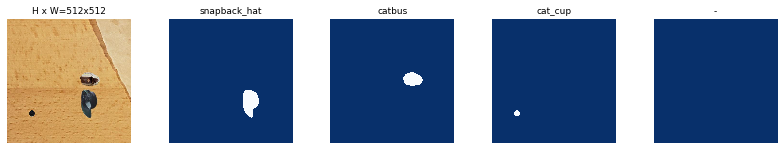

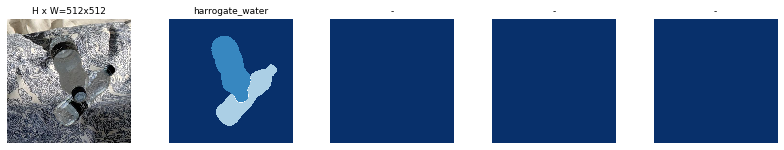

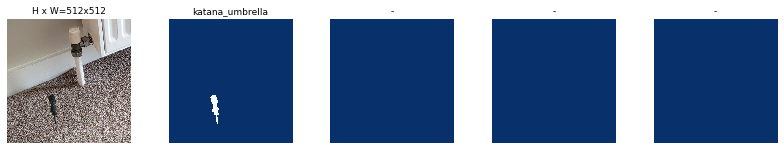

Displaying examples from validation dataset:


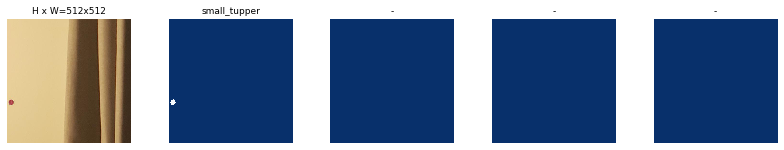

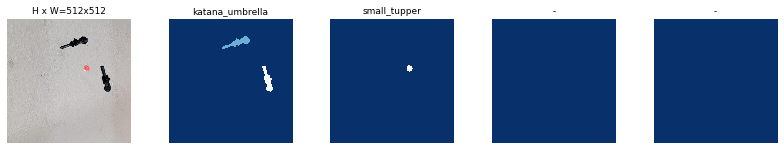

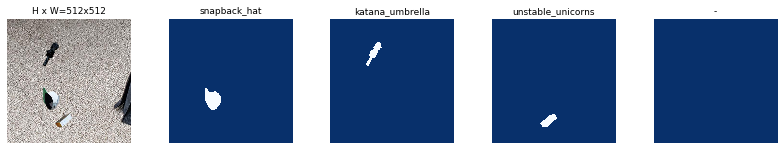

In [20]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 3)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook in the Matterport repo.

In [32]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [33]:
import matplotlib.pyplot as plt
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 30


In [60]:
# augmentation = imgaug.augmenters.Sometimes(0.5, [
#     imgaug.augmenters.Fliplr(0.5),
#     imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
# ])

In [34]:
# Extra augmentation
augmentation = imgaug.augmenters.Sequential([
    imgaug.augmenters.Fliplr(0.5), # Horizontal flips
    imgaug.augmenters.Crop(percent=(0, 0.1)), # Random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    imgaug.augmenters.Sometimes(0.5, 
        imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
    ),
    # Strengthen or weaken the contrast in each image.
    imgaug.augmenters.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    imgaug.augmenters.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    imgaug.augmenters.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)
# es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

In [63]:
# import tensorflow as tf
# with tf.device('/device:GPU:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)
#     # Creates a session with log_device_placement set to True.
#     sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
#     # Runs the op.
#     r = sess.run(c)
#     print(r)
#     import numpy as np
#     assert np.all(r == np.array([[22., 28.], [49., 64.]]))

In [64]:
#from tensorflow.python.client import device_lib

#print(device_lib.list_local_devices())

## Training
Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers='all' to train all layers.

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=160,
            layers='heads',
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 100. LR=0.001

Checkpoint Path: F:/Mask_RCNN/logs\cocosynth_dataset20190720T0934\mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribu

W0723 09:28:07.971420 15096 deprecation_wrapper.py:119] From C:\Users\Jesus\Miniconda3\envs\cocosynth\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a den

Epoch 101/160
500/500 [==============================] - 212s 424ms/step - loss: 0.4920 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.2427 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1064 - val_loss: 3.6352 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.2271 - val_mrcnn_class_loss: 2.8219 - val_mrcnn_bbox_loss: 0.2748 - val_mrcnn_mask_loss: 0.3091
Epoch 102/160
500/500 [==============================] - 194s 388ms/step - loss: 0.4699 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.2270 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1035 - val_loss: 3.5676 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.2836 - val_mrcnn_class_loss: 2.7543 - val_mrcnn_bbox_loss: 0.2807 - val_mrcnn_mask_loss: 0.2465
Epoch 103/160
500/500 [==============================] - 200s 399ms/step - loss: 0.4890 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2369 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.1083 - val_loss: 3.6525

500/500 [==============================] - 189s 378ms/step - loss: 0.3964 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1913 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.0968 - val_loss: 3.6967 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.1994 - val_mrcnn_class_loss: 2.7755 - val_mrcnn_bbox_loss: 0.2567 - val_mrcnn_mask_loss: 0.4632
Epoch 123/160
500/500 [==============================] - 193s 385ms/step - loss: 0.4003 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1894 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1035 - val_loss: 3.7547 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.2253 - val_mrcnn_class_loss: 2.9101 - val_mrcnn_bbox_loss: 0.2541 - val_mrcnn_mask_loss: 0.3629
Epoch 124/160
500/500 [==============================] - 192s 383ms/step - loss: 0.4231 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.2051 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.0983 - val_loss: 4.1105 - val_rpn_cla

500/500 [==============================] - 211s 422ms/step - loss: 0.3792 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1748 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1005 - val_loss: 3.7781 - val_rpn_class_loss: 0.0020 - val_rpn_bbox_loss: 0.2445 - val_mrcnn_class_loss: 2.7306 - val_mrcnn_bbox_loss: 0.2310 - val_mrcnn_mask_loss: 0.5700
Epoch 144/160
500/500 [==============================] - 211s 422ms/step - loss: 0.3809 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1758 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0949 - val_loss: 3.8057 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.2027 - val_mrcnn_class_loss: 2.8170 - val_mrcnn_bbox_loss: 0.2274 - val_mrcnn_mask_loss: 0.5566
Epoch 145/160
500/500 [==============================] - 208s 416ms/step - loss: 0.3567 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1669 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0944 - val_loss: 3.8477 - val_rpn_cla

In [12]:
### The winner for now cocosynth_dataset20190720T0934
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# Augmentation to add more different images
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=160,
            layers='heads',
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 100. LR=0.001

Checkpoint Path: F:/Mask_RCNN/logs\cocosynth_dataset20190720T0934\mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribu

W0722 23:04:46.340882 20832 deprecation_wrapper.py:119] From C:\Users\Jesus\Miniconda3\envs\cocosynth\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a den

Epoch 101/160
500/500 [==============================] - 241s 481ms/step - loss: 0.9034 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.4563 - mrcnn_class_loss: 0.1519 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1423 - val_loss: 3.8263 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.2513 - val_mrcnn_class_loss: 3.0599 - val_mrcnn_bbox_loss: 0.2597 - val_mrcnn_mask_loss: 0.2528
Epoch 102/160
500/500 [==============================] - 214s 428ms/step - loss: 0.8703 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.4308 - mrcnn_class_loss: 0.1467 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.1439 - val_loss: 3.6902 - val_rpn_class_loss: 0.0053 - val_rpn_bbox_loss: 0.2937 - val_mrcnn_class_loss: 2.7727 - val_mrcnn_bbox_loss: 0.2460 - val_mrcnn_mask_loss: 0.3725
Epoch 103/160
500/500 [==============================] - 213s 425ms/step - loss: 0.7962 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4138 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1311 - val_loss: 3.4508

500/500 [==============================] - 350s 700ms/step - loss: 0.6658 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.3307 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.1240 - val_loss: 4.1192 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.2281 - val_mrcnn_class_loss: 3.1831 - val_mrcnn_bbox_loss: 0.2449 - val_mrcnn_mask_loss: 0.4606
Epoch 123/160
500/500 [==============================] - 348s 696ms/step - loss: 0.6801 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.3486 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.1215 - val_loss: 4.1276 - val_rpn_class_loss: 0.0038 - val_rpn_bbox_loss: 0.3125 - val_mrcnn_class_loss: 2.9087 - val_mrcnn_bbox_loss: 0.2784 - val_mrcnn_mask_loss: 0.6242
Epoch 124/160
500/500 [==============================] - 339s 678ms/step - loss: 0.6796 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.3443 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.1223 - val_loss: 3.7796 - val_rpn_cla

500/500 [==============================] - 341s 682ms/step - loss: 0.6283 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.3302 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1211 - val_loss: 3.5983 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.2302 - val_mrcnn_class_loss: 2.7575 - val_mrcnn_bbox_loss: 0.2182 - val_mrcnn_mask_loss: 0.3897
Epoch 144/160
500/500 [==============================] - 344s 688ms/step - loss: 0.6372 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.3322 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1163 - val_loss: 3.9573 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.2511 - val_mrcnn_class_loss: 2.9611 - val_mrcnn_bbox_loss: 0.2407 - val_mrcnn_mask_loss: 0.5020
Epoch 145/160
500/500 [==============================] - 343s 686ms/step - loss: 0.6455 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.3432 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1193 - val_loss: 4.1029 - val_rpn_cla

In [18]:
# 300 epochs, train 200, then 100 (due to hard disk capacity)
# Lots of augmentation
# 10000 images
# 500 steps per epoch
# 50 steps per epoch for validation

# Augmentation to add more different images
augmentation = imgaug.augmenters.Sequential([
    imgaug.augmenters.Fliplr(0.5), # Horizontal flips
    imgaug.augmenters.Crop(percent=(0, 0.1)), # Random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    imgaug.augmenters.Sometimes(0.5, 
        imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
    ),
    # Strengthen or weaken the contrast in each image.
    imgaug.augmenters.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    imgaug.augmenters.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    imgaug.augmenters.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=200,
            layers='heads',
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: F:/Mask_RCNN/logs\cocosynth_dataset20190724T0156\mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

W0724 01:57:20.978008 12228 deprecation_wrapper.py:119] From C:\Users\Jesus\Miniconda3\envs\cocosynth\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a den

Epoch 1/200
500/500 [==============================] - 219s 439ms/step - loss: 2.0439 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.8653 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.4965 - mrcnn_mask_loss: 0.4071 - val_loss: 1.6931 - val_rpn_class_loss: 0.0211 - val_rpn_bbox_loss: 0.6633 - val_mrcnn_class_loss: 0.3781 - val_mrcnn_bbox_loss: 0.4662 - val_mrcnn_mask_loss: 0.1644
Epoch 2/200
500/500 [==============================] - 208s 416ms/step - loss: 1.5604 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7315 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.3473 - mrcnn_mask_loss: 0.1899 - val_loss: 2.3451 - val_rpn_class_loss: 0.0115 - val_rpn_bbox_loss: 0.5031 - val_mrcnn_class_loss: 1.2838 - val_mrcnn_bbox_loss: 0.3902 - val_mrcnn_mask_loss: 0.1565
Epoch 3/200
500/500 [==============================] - 207s 415ms/step - loss: 1.4108 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5875 - mrcnn_class_loss: 0.3288 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.1818 - val_loss: 2.5642 - val

500/500 [==============================] - 208s 417ms/step - loss: 0.8147 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.3607 - mrcnn_class_loss: 0.1449 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.1491 - val_loss: 2.8638 - val_rpn_class_loss: 0.0040 - val_rpn_bbox_loss: 0.2474 - val_mrcnn_class_loss: 2.1068 - val_mrcnn_bbox_loss: 0.2830 - val_mrcnn_mask_loss: 0.2226
Epoch 23/200
500/500 [==============================] - 208s 416ms/step - loss: 0.7742 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.3508 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1392 - val_loss: 2.6864 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.2457 - val_mrcnn_class_loss: 1.9840 - val_mrcnn_bbox_loss: 0.2728 - val_mrcnn_mask_loss: 0.1810
Epoch 24/200
500/500 [==============================] - 209s 418ms/step - loss: 0.8271 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.3816 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.1564 - val_loss: 2.6228 - val_rpn_class

500/500 [==============================] - 208s 415ms/step - loss: 0.6870 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.3174 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.1399 - val_loss: 2.9148 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0.3327 - val_mrcnn_class_loss: 2.1425 - val_mrcnn_bbox_loss: 0.2290 - val_mrcnn_mask_loss: 0.2074
Epoch 44/200
500/500 [==============================] - 207s 414ms/step - loss: 0.6804 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.3274 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.1349 - val_loss: 2.7609 - val_rpn_class_loss: 0.0041 - val_rpn_bbox_loss: 0.2453 - val_mrcnn_class_loss: 2.1041 - val_mrcnn_bbox_loss: 0.2276 - val_mrcnn_mask_loss: 0.1798
Epoch 45/200
500/500 [==============================] - 209s 418ms/step - loss: 0.6867 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.3199 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1386 - val_loss: 2.7395 - val_rpn_class

500/500 [==============================] - 205s 409ms/step - loss: 0.5980 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2775 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.1336 - val_loss: 3.3117 - val_rpn_class_loss: 0.0044 - val_rpn_bbox_loss: 0.3020 - val_mrcnn_class_loss: 2.5602 - val_mrcnn_bbox_loss: 0.2322 - val_mrcnn_mask_loss: 0.2130
Epoch 65/200
500/500 [==============================] - 207s 414ms/step - loss: 0.6263 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.3045 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1312 - val_loss: 3.4079 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.2188 - val_mrcnn_class_loss: 2.7373 - val_mrcnn_bbox_loss: 0.2161 - val_mrcnn_mask_loss: 0.2332
Epoch 66/200
500/500 [==============================] - 209s 418ms/step - loss: 0.6432 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.3067 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1032 - mrcnn_mask_loss: 0.1333 - val_loss: 2.6592 - val_rpn_class

500/500 [==============================] - 208s 416ms/step - loss: 0.6130 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.3114 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.1284 - val_loss: 2.9701 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.1584 - val_mrcnn_class_loss: 2.2917 - val_mrcnn_bbox_loss: 0.1702 - val_mrcnn_mask_loss: 0.3483
Epoch 86/200
500/500 [==============================] - 207s 415ms/step - loss: 0.5987 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.3025 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1262 - val_loss: 2.9133 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 0.2005 - val_mrcnn_class_loss: 2.1483 - val_mrcnn_bbox_loss: 0.2106 - val_mrcnn_mask_loss: 0.3503
Epoch 87/200
500/500 [==============================] - 208s 416ms/step - loss: 0.5771 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.2727 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1329 - val_loss: 2.8527 - val_rpn_class

500/500 [==============================] - 206s 413ms/step - loss: 0.5254 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.2450 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1269 - val_loss: 3.1381 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.2338 - val_mrcnn_class_loss: 2.3830 - val_mrcnn_bbox_loss: 0.1813 - val_mrcnn_mask_loss: 0.3375
Epoch 107/200
500/500 [==============================] - 207s 413ms/step - loss: 0.5469 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2592 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1212 - val_loss: 2.6969 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.2102 - val_mrcnn_class_loss: 2.0581 - val_mrcnn_bbox_loss: 0.1559 - val_mrcnn_mask_loss: 0.2700
Epoch 108/200
500/500 [==============================] - 208s 417ms/step - loss: 0.5363 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2585 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1195 - val_loss: 2.6349 - val_rpn_cla

500/500 [==============================] - 206s 411ms/step - loss: 0.5554 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.2677 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1270 - val_loss: 3.3853 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.1640 - val_mrcnn_class_loss: 2.6384 - val_mrcnn_bbox_loss: 0.1466 - val_mrcnn_mask_loss: 0.4344
Epoch 128/200
500/500 [==============================] - 206s 413ms/step - loss: 0.5520 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.2564 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1297 - val_loss: 3.2002 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.1727 - val_mrcnn_class_loss: 2.5086 - val_mrcnn_bbox_loss: 0.1846 - val_mrcnn_mask_loss: 0.3326
Epoch 129/200
500/500 [==============================] - 207s 414ms/step - loss: 0.6048 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.3137 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1264 - val_loss: 3.3104 - val_rpn_cla

500/500 [==============================] - 210s 420ms/step - loss: 0.5118 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.2461 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1217 - val_loss: 3.2640 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.2238 - val_mrcnn_class_loss: 2.5529 - val_mrcnn_bbox_loss: 0.1759 - val_mrcnn_mask_loss: 0.3090
Epoch 149/200
500/500 [==============================] - 209s 417ms/step - loss: 0.5499 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.2752 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1254 - val_loss: 2.8048 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.1823 - val_mrcnn_class_loss: 2.0237 - val_mrcnn_bbox_loss: 0.1716 - val_mrcnn_mask_loss: 0.4255
Epoch 150/200
500/500 [==============================] - 208s 417ms/step - loss: 0.5355 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.2650 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1208 - val_loss: 2.7878 - val_rpn_cla

500/500 [==============================] - 206s 412ms/step - loss: 0.5511 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.2769 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1210 - val_loss: 3.0671 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 0.2002 - val_mrcnn_class_loss: 2.2970 - val_mrcnn_bbox_loss: 0.1545 - val_mrcnn_mask_loss: 0.4116
Epoch 170/200
500/500 [==============================] - 208s 415ms/step - loss: 0.5099 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1219 - val_loss: 3.2191 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.1815 - val_mrcnn_class_loss: 2.5254 - val_mrcnn_bbox_loss: 0.1455 - val_mrcnn_mask_loss: 0.3651
Epoch 171/200
500/500 [==============================] - 207s 414ms/step - loss: 0.5296 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2564 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1237 - val_loss: 2.7381 - val_rpn_cla

500/500 [==============================] - 207s 414ms/step - loss: 0.4998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1200 - val_loss: 3.1605 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.1273 - val_mrcnn_class_loss: 2.5694 - val_mrcnn_bbox_loss: 0.1359 - val_mrcnn_mask_loss: 0.3263
Epoch 191/200
500/500 [==============================] - 207s 414ms/step - loss: 0.5112 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.2443 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1209 - val_loss: 3.1012 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.1479 - val_mrcnn_class_loss: 2.4083 - val_mrcnn_bbox_loss: 0.1398 - val_mrcnn_mask_loss: 0.4030
Epoch 192/200
500/500 [==============================] - 206s 413ms/step - loss: 0.5140 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.2650 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1189 - val_loss: 3.0703 - val_rpn_cla

In [62]:
# Start from last checkpoint, 300 epocks
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=300,
            layers='heads',
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 200. LR=0.001

Checkpoint Path: F:/Mask_RCNN/logs\cocosynth_dataset20190724T0156\mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribu

C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 201/300
500/500 [==============================] - 217s 435ms/step - loss: 0.5288 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.2659 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1229 - val_loss: 2.8511 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.1448 - val_mrcnn_class_loss: 2.2147 - val_mrcnn_bbox_loss: 0.1662 - val_mrcnn_mask_loss: 0.3231
Epoch 202/300
500/500 [==============================] - 212s 425ms/step - loss: 0.4930 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.2549 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1135 - val_loss: 3.2497 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.1349 - val_mrcnn_class_loss: 2.5398 - val_mrcnn_bbox_loss: 0.1497 - val_mrcnn_mask_loss: 0.4242
Epoch 203/300
500/500 [==============================] - 212s 424ms/step - loss: 0.4860 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.2328 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1179 - val_loss: 2.9708

500/500 [==============================] - 210s 419ms/step - loss: 0.5416 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.2849 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1181 - val_loss: 2.8646 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.1490 - val_mrcnn_class_loss: 2.2264 - val_mrcnn_bbox_loss: 0.1219 - val_mrcnn_mask_loss: 0.3659
Epoch 223/300
500/500 [==============================] - 211s 421ms/step - loss: 0.4906 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2359 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1180 - val_loss: 2.8419 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.1694 - val_mrcnn_class_loss: 2.2354 - val_mrcnn_bbox_loss: 0.1516 - val_mrcnn_mask_loss: 0.2838
Epoch 224/300
500/500 [==============================] - 210s 420ms/step - loss: 0.4983 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1214 - val_loss: 3.0412 - val_rpn_cla

500/500 [==============================] - 208s 417ms/step - loss: 0.4899 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2338 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1143 - val_loss: 3.3223 - val_rpn_class_loss: 0.0036 - val_rpn_bbox_loss: 0.2246 - val_mrcnn_class_loss: 2.4804 - val_mrcnn_bbox_loss: 0.1630 - val_mrcnn_mask_loss: 0.4506
Epoch 244/300
500/500 [==============================] - 210s 420ms/step - loss: 0.4699 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.2309 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1138 - val_loss: 3.4402 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.1948 - val_mrcnn_class_loss: 2.5573 - val_mrcnn_bbox_loss: 0.1596 - val_mrcnn_mask_loss: 0.5261
Epoch 245/300
500/500 [==============================] - 209s 419ms/step - loss: 0.5092 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2624 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1162 - val_loss: 3.1859 - val_rpn_cla

500/500 [==============================] - 210s 419ms/step - loss: 0.4486 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1178 - val_loss: 3.1829 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.1413 - val_mrcnn_class_loss: 2.4063 - val_mrcnn_bbox_loss: 0.1186 - val_mrcnn_mask_loss: 0.5142
Epoch 265/300
500/500 [==============================] - 209s 419ms/step - loss: 0.5452 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.2816 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1182 - val_loss: 3.1904 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.1619 - val_mrcnn_class_loss: 2.4531 - val_mrcnn_bbox_loss: 0.1282 - val_mrcnn_mask_loss: 0.4457
Epoch 266/300
500/500 [==============================] - 210s 420ms/step - loss: 0.4797 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.2323 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1174 - val_loss: 3.1528 - val_rpn_cla

500/500 [==============================] - 209s 419ms/step - loss: 0.4641 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.2205 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1133 - val_loss: 2.8828 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.2177 - val_mrcnn_class_loss: 2.2367 - val_mrcnn_bbox_loss: 0.1392 - val_mrcnn_mask_loss: 0.2865
Epoch 286/300
500/500 [==============================] - 210s 419ms/step - loss: 0.4448 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1094 - val_loss: 3.0546 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.1127 - val_mrcnn_class_loss: 2.4041 - val_mrcnn_bbox_loss: 0.1242 - val_mrcnn_mask_loss: 0.4119
Epoch 287/300
500/500 [==============================] - 209s 419ms/step - loss: 0.4730 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.2352 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1165 - val_loss: 3.6882 - val_rpn_cla

In [24]:
# Epochs 1-30
# 1000 steps per epoch
# 100 steps in validation
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100,
            layers='heads',
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: F:/Mask_RCNN/logs\cocosynth_dataset20190727T1023\mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

W0727 10:24:12.328375 27480 deprecation_wrapper.py:119] From C:\Users\Jesus\Miniconda3\envs\cocosynth\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a den

Epoch 1/100
1000/1000 [==============================] - 723s 723ms/step - loss: 1.8006 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.7942 - mrcnn_class_loss: 0.2729 - mrcnn_bbox_loss: 0.3829 - mrcnn_mask_loss: 0.3324 - val_loss: 2.4979 - val_rpn_class_loss: 0.0111 - val_rpn_bbox_loss: 0.4792 - val_mrcnn_class_loss: 1.4526 - val_mrcnn_bbox_loss: 0.3517 - val_mrcnn_mask_loss: 0.2033
Epoch 2/100
1000/1000 [==============================] - 710s 710ms/step - loss: 1.2224 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.5612 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.2295 - mrcnn_mask_loss: 0.1722 - val_loss: 2.8592 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.3631 - val_mrcnn_class_loss: 2.0000 - val_mrcnn_bbox_loss: 0.3304 - val_mrcnn_mask_loss: 0.1598
Epoch 3/100
1000/1000 [==============================] - 711s 711ms/step - loss: 1.0812 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.5098 - mrcnn_class_loss: 0.2051 - mrcnn_bbox_loss: 0.1956 - mrcnn_mask_loss: 0.1638 - val_loss: 2.8594

1000/1000 [==============================] - 712s 712ms/step - loss: 0.6397 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.3069 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1333 - val_loss: 3.2374 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.2019 - val_mrcnn_class_loss: 2.3777 - val_mrcnn_bbox_loss: 0.2114 - val_mrcnn_mask_loss: 0.4437
Epoch 23/100
1000/1000 [==============================] - 712s 712ms/step - loss: 0.6124 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1284 - val_loss: 3.2712 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0.2138 - val_mrcnn_class_loss: 2.4960 - val_mrcnn_bbox_loss: 0.2119 - val_mrcnn_mask_loss: 0.3462
Epoch 24/100
1000/1000 [==============================] - 714s 714ms/step - loss: 0.6093 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.2962 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1283 - val_loss: 3.3936 - val_rpn

KeyboardInterrupt: 

In [35]:
# Epochs 31-100
# 1000 steps per epoch
# 100 steps in validation
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100,
            layers='heads',
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 30. LR=0.001

Checkpoint Path: F:/Mask_RCNN/logs\cocosynth_dataset20190727T1023\mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribut

C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 31/100
1000/1000 [==============================] - 1690s 2s/step - loss: 0.5806 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.2840 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1245 - val_loss: 3.2621 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.1879 - val_mrcnn_class_loss: 2.4583 - val_mrcnn_bbox_loss: 0.1904 - val_mrcnn_mask_loss: 0.4229
Epoch 32/100
1000/1000 [==============================] - 1668s 2s/step - loss: 0.5590 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1243 - val_loss: 3.4654 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.1836 - val_mrcnn_class_loss: 2.5800 - val_mrcnn_bbox_loss: 0.1994 - val_mrcnn_mask_loss: 0.4999
Epoch 33/100
1000/1000 [==============================] - 1678s 2s/step - loss: 0.5910 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.2921 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1256 - val_loss: 3.6595 - 

1000/1000 [==============================] - 1665s 2s/step - loss: 0.5005 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.2434 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1176 - val_loss: 3.2596 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.1754 - val_mrcnn_class_loss: 2.4922 - val_mrcnn_bbox_loss: 0.1657 - val_mrcnn_mask_loss: 0.4242
Epoch 53/100
1000/1000 [==============================] - 1675s 2s/step - loss: 0.5004 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2450 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1175 - val_loss: 3.4377 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.1705 - val_mrcnn_class_loss: 2.6467 - val_mrcnn_bbox_loss: 0.1638 - val_mrcnn_mask_loss: 0.4548
Epoch 54/100
  13/1000 [..............................] - ETA: 26:07 - loss: 0.4978 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1101

KeyboardInterrupt: 

In [13]:
def releaseGPUMemory():
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
    
releaseGPUMemory()

In [38]:
config = CocoSynthConfig()
config.IMAGES_PER_GPU = 1
config.STEPS_PER_EPOCH = 500
config.VALIDATION_STEPS = 50
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [39]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=161, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 160. LR=0.0001

Checkpoint Path: F:/Mask_RCNN/logs\cocosynth_dataset20190720T0934\mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Co

C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 161/161
500/500 [==============================] - 284s 568ms/step - loss: 0.3058 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.1439 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0834 - val_loss: 3.6778 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.2082 - val_mrcnn_class_loss: 2.7655 - val_mrcnn_bbox_loss: 0.2300 - val_mrcnn_mask_loss: 0.4724
Training took 6.14 minutes


In [25]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=110, 
            layers="all",
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 103. LR=0.0001

Checkpoint Path: F:/Mask_RCNN/logs\cocosynth_dataset20190720T0934\mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Co

C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Jesus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 104/110
500/500 [==============================] - 326s 652ms/step - loss: 0.8815 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4157 - mrcnn_class_loss: 0.1700 - mrcnn_bbox_loss: 0.1339 - mrcnn_mask_loss: 0.1560 - val_loss: 4.0433 - val_rpn_class_loss: 0.0028 - val_rpn_bbox_loss: 0.2369 - val_mrcnn_class_loss: 3.1674 - val_mrcnn_bbox_loss: 0.2870 - val_mrcnn_mask_loss: 0.3493
Epoch 105/110
500/500 [==============================] - 307s 615ms/step - loss: 0.8587 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4568 - mrcnn_class_loss: 0.1520 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.1238 - val_loss: 3.3564 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.2163 - val_mrcnn_class_loss: 2.6719 - val_mrcnn_bbox_loss: 0.2463 - val_mrcnn_mask_loss: 0.2186
Epoch 106/110
500/500 [==============================] - 307s 613ms/step - loss: 0.8032 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.4290 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.1287 - val_loss: 3.4504

# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [9]:
class InferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.90
    

inference_config = InferenceConfig()

In [10]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

W0726 00:03:19.597624 27480 deprecation_wrapper.py:119] From C:\Users\Jesus\Miniconda3\envs\cocosynth\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 00:03:19.616624 27480 deprecation_wrapper.py:119] From C:\Users\Jesus\Miniconda3\envs\cocosynth\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 00:03:19.621623 27480 deprecation_wrapper.py:119] From C:\Users\Jesus\Miniconda3\envs\cocosynth\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 00:03:19.648622 27480 deprecation_wrapper.py:119] From C:\Users\Jesus\Miniconda3\envs\cocosynth\lib\site-packages\keras\backend\tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm i

### Load Trained Weights
Note: The code is set to find_last() by default, but you can also point the model to a specific pretrained weights file if you use line 3 instead of line 4.

In [11]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = str(Path(ROOT_DIR) / "logs" / "box_synthetic20190328T2255/mask_rcnn_box_synthetic_0016.h5" )
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  F:/Mask_RCNN/logs\cocosynth_dataset20190724T0156\mask_rcnn_cocosynth_dataset_0300.h5
Re-starting from epoch 300


# Image Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

You can adjust the "figsize" in the cell below to make the image larger or smaller.

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


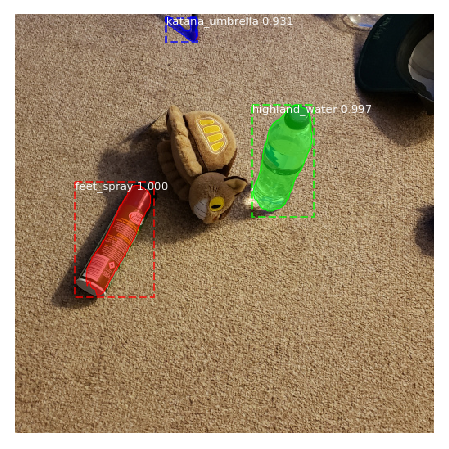

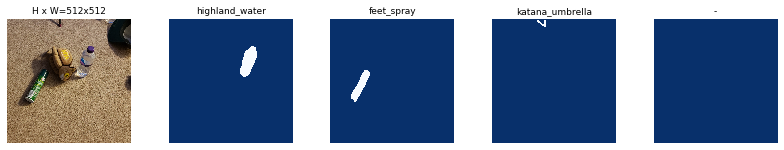

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


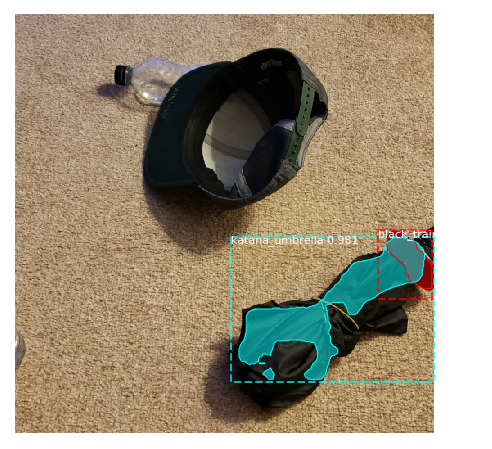

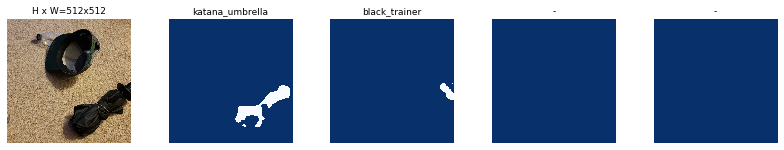

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


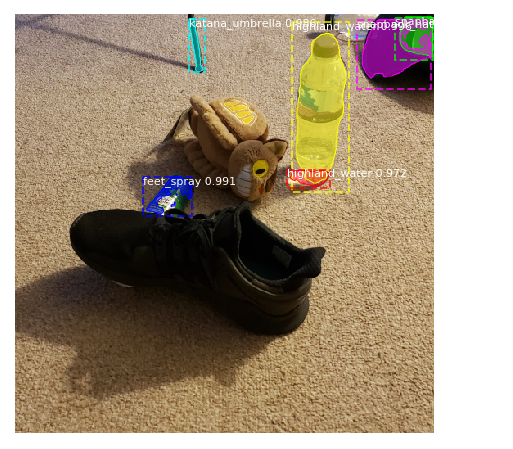

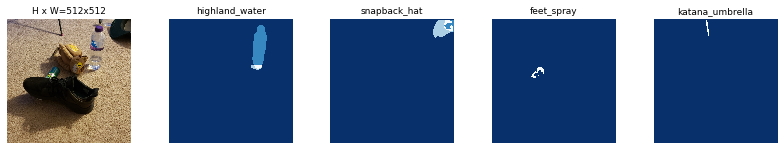

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


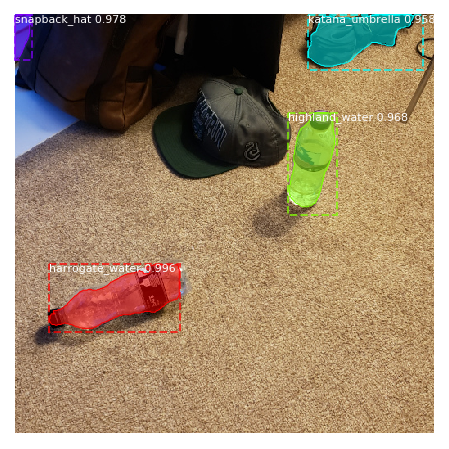

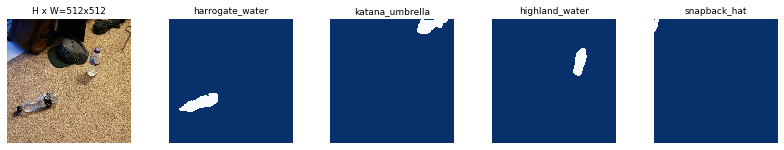

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


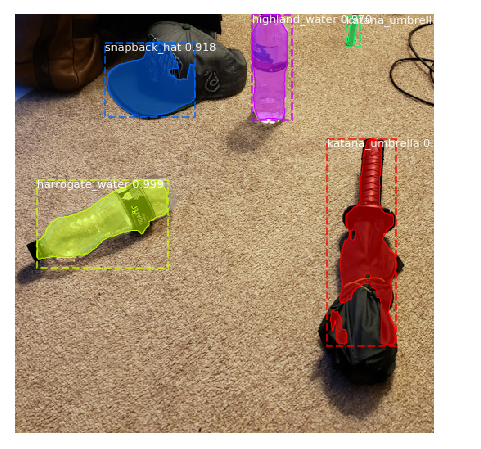

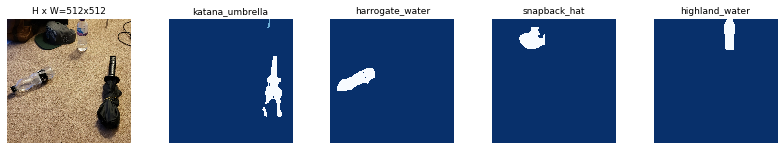

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


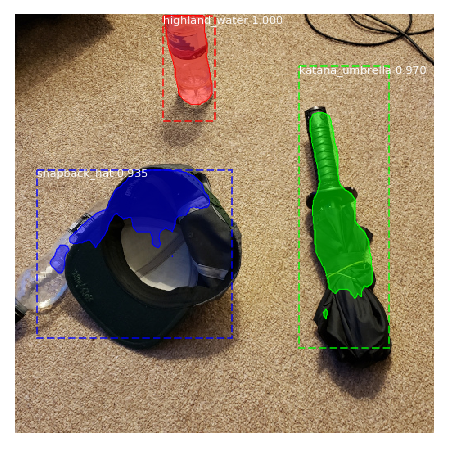

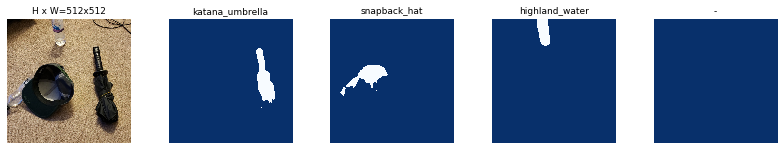

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


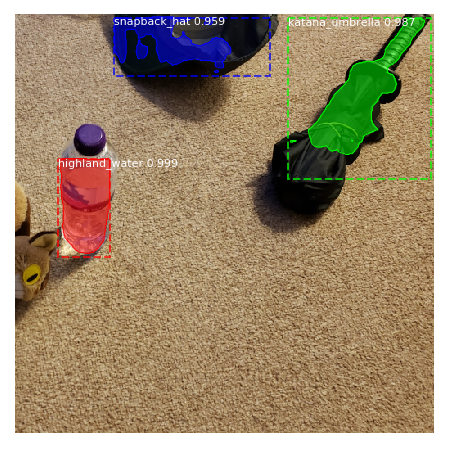

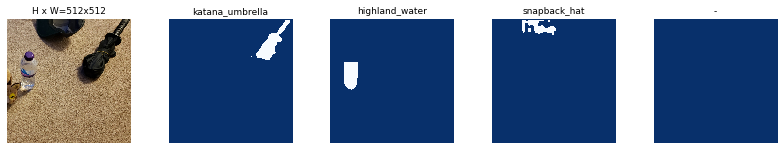

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


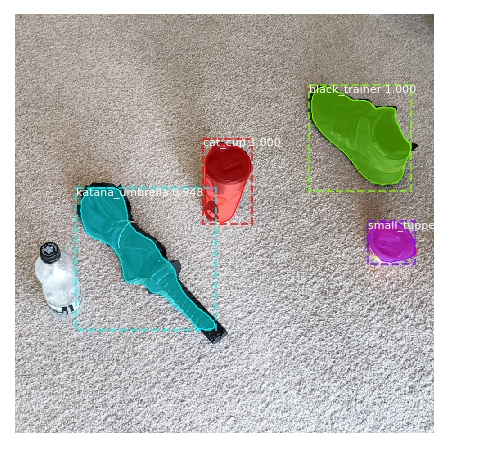

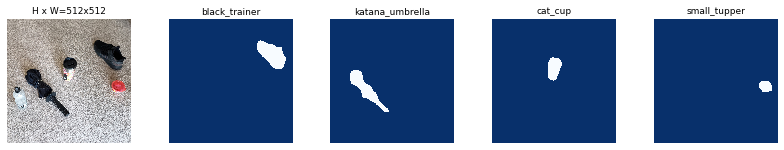

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


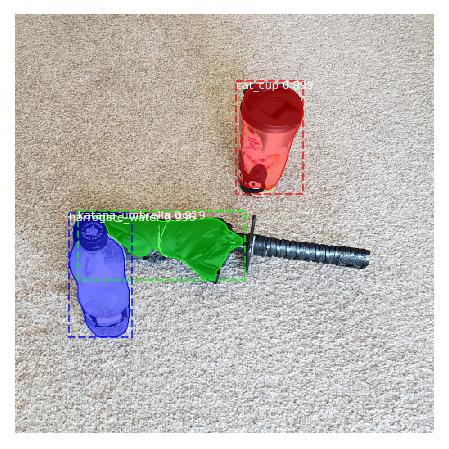

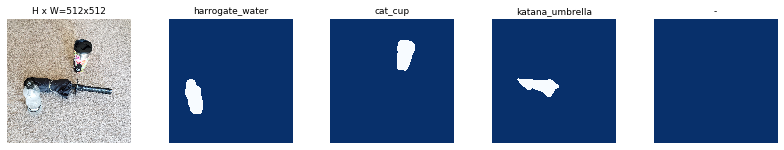

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


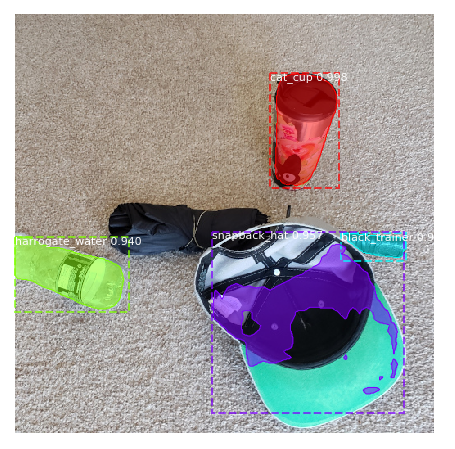

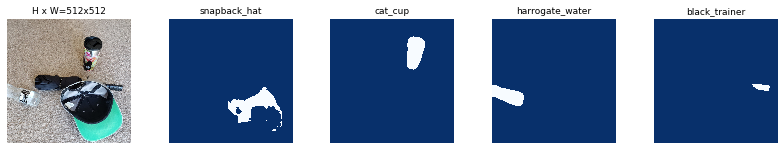

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


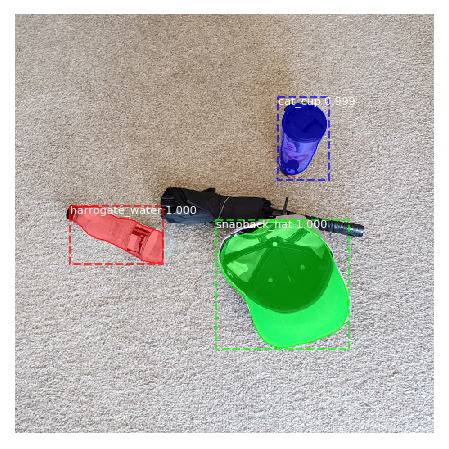

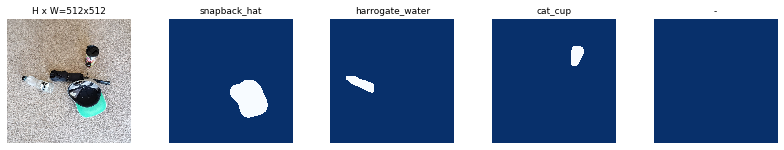

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


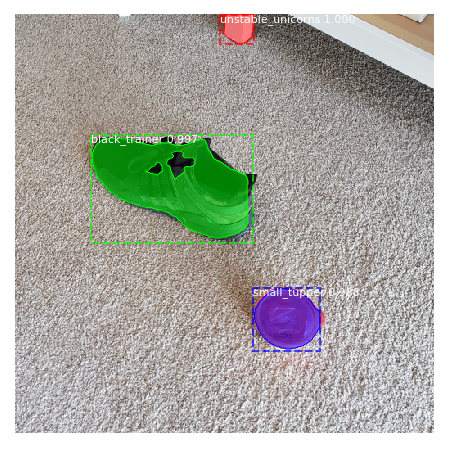

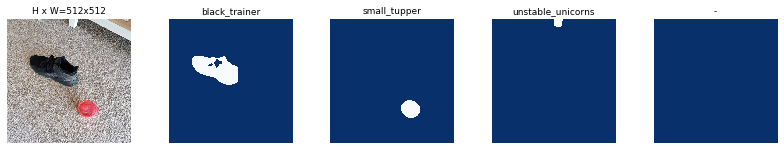

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



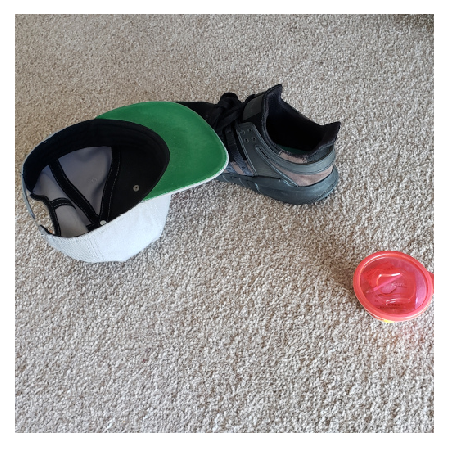

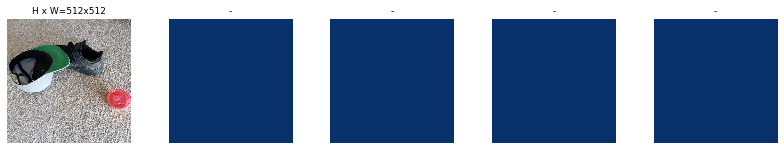

In [12]:
import skimage

real_test_dir = '../../cocosynth/datasets/dataset_synthetic/test/images'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    # image, boxes, masks, class_ids, class_names, scores=None, title="", figsize=(16, 16), ax=None,
    # show_mask=True, show_bbox=True, colors=None, captions=None
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], figsize=(8,8))
    visualize.display_top_masks(img, r['masks'], r['class_ids'], 
                                dataset_train.class_names, limit=4)

# Video Inference
## Prepare to run Video Inference
Note: This code is adapted from https://www.dlology.com/blog/how-to-run-object-detection-and-segmentation-on-video-fast-for-free/ created by Chengwei Zhang.

In this section, we'll open up a video, run inference on it, and output a new video with segmentations and labels.

In [71]:
video_file = Path("../../cocosynth/datasets/dataset_synthetic/videotest/20190722_192357.mp4")
video_save_dir = Path("../../cocosynth/datasets/dataset_synthetic/videotest/save")
video_save_dir.mkdir(exist_ok=True)

### Adjust Config Parameters
Depending on the resolution of your video, you may want to update the parameters below.

Mask R-CNN requires IMAGE_MIN_DIM to be divisible by 2, six times, so that's why I'm using 1088 instead of 1080, which is the actual height of the video.

In [72]:
class VideoInferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 1088
    IMAGE_MAX_DIM = 1920
    IMAGE_SHAPE = [1920, 1080, 3]
    DETECTION_MIN_CONFIDENCE = 0.90
    

inference_config = VideoInferenceConfig()

### Set Up Model and Load Trained Weights

In [73]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [74]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = str(Path(ROOT_DIR) / "logs" / "box_synthetic20190328T2255/mask_rcnn_box_synthetic_0016.h5" )
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  F:/Mask_RCNN/logs\cocosynth_dataset20190724T0156\mask_rcnn_cocosynth_dataset_0300.h5
Re-starting from epoch 300


In [75]:
import cv2
import skimage
import random
import colorsys
from tqdm import tqdm

In [76]:
def random_colors(N, bright=True):
    """ Generate random colors. 
        To get visually distinct colors, generate them in HSV space then
        convert to RGB.
    Args:
        N: the number of colors to generate
        bright: whether or not to use bright colors
    Returns:
        a list of RGB colors, e.g [(0.0, 1.0, 0.0), (1.0, 0.0, 0.5), ...]
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """ Apply the given mask to the image.
    Args:
        image: a cv2 image
        mask: a mask of which pixels to color
        color: the color to use
        alpha: how visible the mask should be (0 to 1)
    Returns:
        a cv2 image with mask applied
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def display_instances(image, boxes, masks, ids, names, scores, colors):
    """ Take the image and results and apply the mask, box, and label
    Args:
        image: a cv2 image
        boxes: a list of bounding boxes to display
        masks: a list of masks to display
        ids: a list of class ids
        names: a list of class names corresponding to the ids
        scores: a list of scores of each instance detected
        colors: a list of colors to use
    Returns:
        a cv2 image with instances displayed   
    """
    n_instances = boxes.shape[0]

    if not n_instances:
        return image # no instances
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        # Check if any boxes to show
        if not np.any(boxes[i]):
            continue
        
        # Check if any scores to show
        if scores is not None:
            score = scores[i] 
        else:
            score = None

        # Add the mask
        image = apply_mask(image, masks[:, :, i], color)
        
        # Add the bounding box
        y1, x1, y2, x2 = boxes[i]
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        
        # Add the label
        label = names[ids[i]]
        if score:
            label = f'{label} {score:.2f}'
            
        label_pos = (x1 + (x2 - x1) // 2, y1 + (y2 - y1) // 2) # center of bounding box
        image = cv2.putText(image, label, label_pos, cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 2)

    return image

### Prepare for Inference
Adjust the paths below to point to your video

In [77]:
video_file = Path("../../cocosynth/datasets/dataset_synthetic/videotest/20190722_192357.mp4")
video_save_dir = Path("../../cocosynth/datasets/dataset_synthetic/videotest/save")
video_save_dir.mkdir(exist_ok=True)
vid_name = video_save_dir / "output.mp4"
v_format="FMP4"
fourcc = cv2.VideoWriter_fourcc(*v_format)

print('Writing output video to: ' + str(vid_name))

Writing output video to: ..\..\cocosynth\datasets\dataset_synthetic\videotest\save\output.mp4


Random colors can be a bit intense with video, so I've set it to use the same color for each object. You can try random colors if you like.

Note: cv2 uses BGR (Blue Green Red) color representation instead of RGB (Red Green Blue), so we have to do a couple conversions here

In [78]:
#colors = random_colors(30)
colors = [(1.0, 1.0, 0.0)] * 30

# Change color representation from RGB to BGR before displaying instances
colors = [(color[2], color[1], color[0]) for color in colors]

### Perform Inference on Video
Use the cv2 module to open the video and perform inference on each frame.

In [79]:
input_video = cv2.VideoCapture(str(video_file))
frame_count = int(input_video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(input_video.get(cv2.CAP_PROP_FPS))
output_video = None
vid_size = None
current_frame = 0

for i in tqdm(range(frame_count)):
    # Read the current frame
    ret, frame = input_video.read()
    if not ret:
        break
        
    current_frame += 1
    
    # Change color representation from BGR to RGB before running model.detect()
    detect_frame = frame[:, :, ::-1]        
    
    # Run inference on the color-adjusted frame
    results = model.detect([detect_frame], verbose=0)
    r = results[0]
    n_instances = r['rois'].shape[0]
    
    # Make sure we have enough colors
    if len(colors) < n_instances:
        # not enough colors, generate more
        more_colors = random_colors(n_instances - len(colors))
        
        # Change color representation from RGB to BGR before displaying instances
        more_colors = [(color[2], color[1], color[0]) for color in more_colors]
        colors += more_colors
        
    
    
    # Display instances on the original frame
    display_frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], colors[0:n_instances])

    # Make sure we got displayed instances
    if display_frame is not None:
        frame = display_frame

    # Create the output_video if it doesn't yet exist
    if output_video is None:
        if vid_size is None:
            vid_size = frame.shape[1], frame.shape[0]
        output_video = cv2.VideoWriter(str(vid_name), fourcc, float(fps), vid_size, True)
        
    # Resize frame if necessary
    if vid_size[0] != frame.shape[1] and vid_size[1] != frame.shape[0]:
        frame = cv2.resize(frame, vid_size)
    
    # Write the frame to the output_video
    output_video.write(frame)
    
input_video.release()
output_video.release()

100%|██████████████████████████████████████████████████████████████████████████████| 1068/1068 [24:32<00:00,  1.36s/it]
